In [5]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from  evaluation.core import State
from typing import Dict, List
import datetime
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
from copy import deepcopy
import random
from Rushi.PPO.trainer import PPOTrainer
from Rushi.PPO.ml import PPOAgent
from Rushi.PPO.core import EarlyEnvironment, EarlyEnvs
from Rushi.PPO.utils import Logger, makeFeatures, getInvalidActionMask, getStateFeatures, getStockFeatures, interpolatorNotForDay, addPatterns
from evaluation.core import BaseStrategy
from evaluation.constants import HOLD_ACTION,BUY_ACTION,SELL_ACTION
from Rushi.PPO.constants import MAX_HOLDING, MAX_TRADE_TIME_IN_5_MINUTE, MAX_TRADE_TIME_IN_DAYS,ROLLING_WINDOW_SIZE_IN_DAYS, MAX_TRADE_TIME_IN_MINUTE, MODES, minutes_5_in_day, minutes_in_day, ROLLING_WINDOW_SIZE_IN_MINUTE, ROLLING_WINDOW_SIZE_IN_5_MINUTE,end_time_5_minute, end_time_minute
from Rushi.PPO.constants import end_time_minute, end_time_5_minute
from Rushi.PPO.ppoStrategy import PPOStrategy
from evaluation.backTest import BackTest
from patternpy.tradingpatterns.tradingpatterns import detect_head_shoulder, detect_multiple_tops_bottoms, detect_double_top_bottom, find_pivots
from tqdm import tqdm
import matplotlib.dates as mdates
from evaluation.core import State

In [2]:
#df = pd.read_csv("data/5minute/APOLLOHOSP.csv")
df = pd.read_csv("data/5minute/HDFCBANK.csv")
df = interpolatorNotForDay(df= df, mode= "5minute")
addPatterns(df)

total values interpolated = 1230


In [3]:
df['ema12'] = df['close'].ewm(span=minutes_5_in_day*6, adjust=False).mean()
df['ema26'] = df['close'].ewm(span=minutes_5_in_day*12, adjust=False).mean()
macd = df['ema12'] - df['ema26']

signal = macd.ewm(span=9*minutes_5_in_day, adjust=False).mean()
df["MACD"] = macd
df["MACD_SIGNAL"] = signal



In [4]:
signals = np.where(df["MACD"] > df["MACD_SIGNAL"], 1, -1)
signals_list = [signals[0]]
for i in range(1, len(signals)):
    if signals[i] == signals[i -1]:
        signals_list.append(0)
    else:
        signals_list.append(signals[i])

In [8]:
class MACDStrategy(BaseStrategy):

    def __init__(self,signals_list) -> None:
        super().__init__()
        self.signal_list = signals_list
    def step(self, data, state: State, current_pointer: int):
        
        if current_pointer < 26*minutes_5_in_day:
            return HOLD_ACTION
        
        if self.signal_list[current_pointer] == 0:
            return HOLD_ACTION
        elif self.signal_list[current_pointer] == 1:
            if len(state.values) < MAX_HOLDING:
                return BUY_ACTION
            else:
                return HOLD_ACTION
        else:
            if len(state.values) > 0:
                return SELL_ACTION
            else:
                return HOLD_ACTION
        

In [9]:
back_test = BackTest(data= df,strategy= MACDStrategy(signals_list= signals_list), mode= "multi")

In [10]:
back_test.runStrategy()

Ran from 2019-01-01 09:15:00 to 2024-05-31 15:25:00
Initial value = 10000
Final value = 11655.865749999992


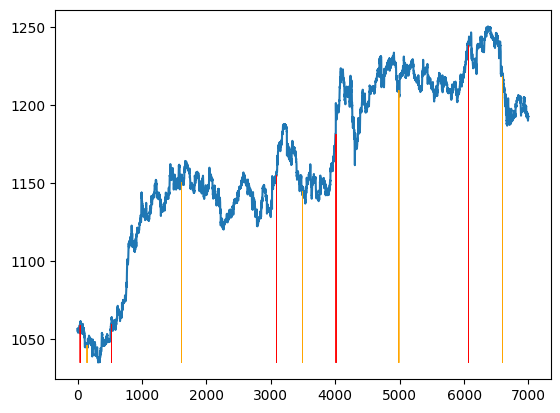

In [11]:
#plt.plot(back_test.log["action"])
lim_start = 3000
lim = 10000
X =  list(range(lim - lim_start))
closing_price = back_test.log["closing_price"][lim_start:lim]
actions = back_test.log["action"][lim_start: lim]
y_mn = min(closing_price)
plt.plot(X,closing_price)

for i,action in enumerate(actions):
    if action == BUY_ACTION:
        plt.plot([i,i],[y_mn,closing_price[i]], c = "red",linewidth = .5)
    elif action == SELL_ACTION:
        plt.plot([i,i],[y_mn,closing_price[i]], c = "orange", linewidth = .5)

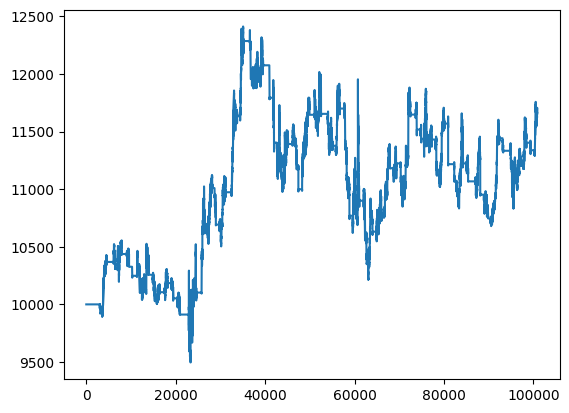

In [12]:
plt.plot(back_test.log["total_value"])